加性注意力机制的理解，代码来源于李沐的课程

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [70]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        print('queries.shape:',queries.shape,'keys.shape:',keys.shape)
        print('queries.unsqueeze(2).shape:',queries.unsqueeze(2).shape,'keys.unsqueeze(1).shape:',keys.unsqueeze(1).shape)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        print('features.shape:',features.shape)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        print('scores.shape:',scores.shape)
        self.attention_weights = masked_softmax(scores, valid_lens)

        print(self.attention_weights)
        print('attention_weights.shape',self.attention_weights.shape)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)

        print('dropout weight:',self.dropout(self.attention_weights).shape)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [71]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
out=attention(queries, keys, values, valid_lens)
print('out.shape:',out.shape)

queries.shape: torch.Size([2, 1, 8]) keys.shape: torch.Size([2, 10, 8])
queries.unsqueeze(2).shape: torch.Size([2, 1, 1, 8]) keys.unsqueeze(1).shape: torch.Size([2, 1, 10, 8])
features.shape: torch.Size([2, 1, 10, 8])
scores.shape: torch.Size([2, 1, 10])
tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward>)
attention_weights.shape torch.Size([2, 1, 10])
dropout weight: torch.Size([2, 1, 10])
out.shape: torch.Size([2, 1, 4])


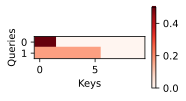

In [69]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [15]:
masked_softmax(torch.rand(2, 2, 5), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2175, 0.4822, 0.3002, 0.0000, 0.0000]],

        [[0.5796, 0.4204, 0.0000, 0.0000, 0.0000],
         [0.2681, 0.2643, 0.2194, 0.2481, 0.0000]]])